<a href="https://colab.research.google.com/github/JNK234/Fast.ai-Projects/blob/master/Classifying%20Unknown%20Labels/Handling_Unknown_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [14]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

## Get the data

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path = (path/'images')

In [5]:
path.ls()[:3]

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_131.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_163.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_100.jpg')]

## Load the data

Using MultiCategory Block instead of Category Block 

In [10]:
pets_multi = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(),
    get_y = Pipeline([RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'), lambda label: [label]]),
    item_tfms = RandomResizedCrop(460, min_scale=0.75),
    batch_tfms = [*aug_transforms(size = 224, max_warp=0), 
                  Normalize.from_stats(*imagenet_stats)]
)

In [12]:
dls = pets_multi.dataloaders(path, bs=32)

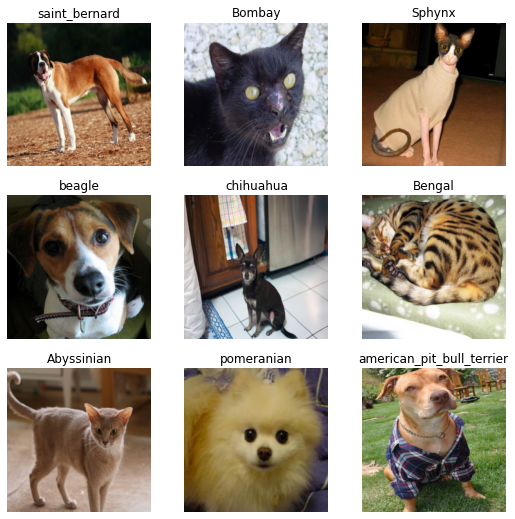

In [13]:
dls.show_batch()

## Training Our Model

The metric will use a very high threshold so that only highly confident predictions are accepted as correct. The loss function, however, uses the default 0.5 threshold so that the model is not incentivated to make extreme predictions even if unsure.

In [15]:
learn = cnn_learner(dls, resnet34, pretrained=True, 
                    metrics = [partial(accuracy_multi, thresh=0.95)], 
                    loss_func = BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [16]:
learn.fine_tune(epochs = 4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.415924,0.065469,0.973869,01:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.051931,0.022835,0.982427,01:06
1,0.025898,0.014289,0.989577,01:06
2,0.015671,0.010644,0.992539,01:05
3,0.010434,0.009838,0.993234,01:06


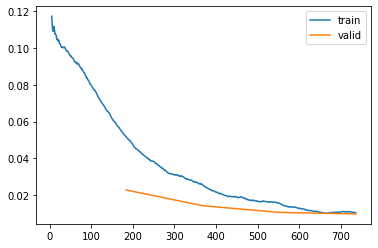

In [17]:
learn.recorder.plot_loss()

## Model Evaluation

In [36]:
learn.loss_func = BCEWithLogitsLossFlat(thresh=0.95)

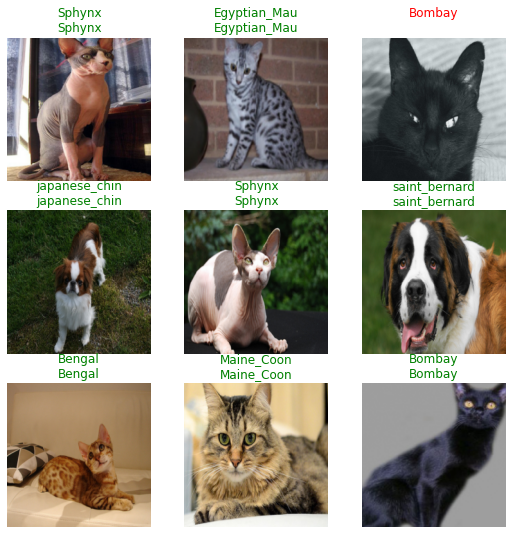

In [37]:
learn.show_results()

In [38]:
p = Path()

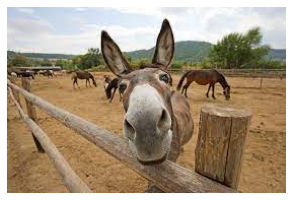

In [39]:
img = PILImage.create(p/'donkey2.jpg')
img.show()

In [40]:
learn.predict(img)[0]

(#0) []

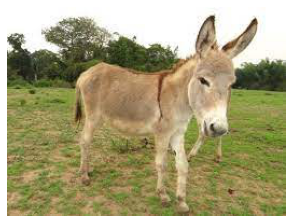

In [41]:
img1 = PILImage.create(p/'donkey1.jpg')
img1.show()

In [28]:
learn.predict(img1)[0]

(#0) []

Now our classifier is smart enough to not return any label if the image doesn't belong to any class it is trained on.
 

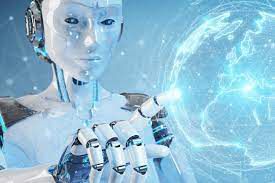

In [29]:
imgai = PILImage.create(p/'ai1.jpg')
imgai

In [30]:
learn.predict(imgai)[0]

(#0) []